In [207]:
"""
Created on Thu Sep 22 13:06:00 2022

# Explorative Data Analysis Workshop 1  (Statistics for DS)


The instructions in this file assume that you are using Spyder by Anaconda. 
They might be different if you are using Jupyler. For example: Jupyler prints
all columns when you use the command df.head(). Spyder just prints some columns, 
it is desirable to use the Variable Explorer instead. 


# Objective:
    1.- Execute a simple EDA.
    2.- Clean DATA
    3.- Plot Distributions and Box Plots
    4.- Proof that there is a relationship between area and house cost.
    5.- Plot a Categorial Data
    6.- Plot a Correlation Matrix
 
    
@author: Alejandro Murrieta-Mendoza
"""
# 0: Import all your required libreries 
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

import pandas as pd
import numpy as np

import math

In [208]:
df = pd.read_csv('./salaries.csv')
df.head()

original_shape = df.shape



Rename columns

In [209]:
columns = ["timestamp", "age", "industry", "job_title", "job_title_info", "salary", "add_comp", "currency", "other_curr", "additional_context", "country", "us_state", "city", "overall_exp", "job_exp", "education", "gender", "race"]
df.columns = columns

df.columns

len(df['country'].unique())

369

Remove unwanted columns

### Explanation
* industry: Too many possible values
* Job Title: Too many possible values
* other_curr: Will only take account of currencies selected in the previous column, other values will be dropped
* Additional_context: Unwanted information
* city: Too many possible values
* us_state: Will only look at countries here
* race: Messy column, according to some answers, don't have to explain my reasoning here, see an answer from the survey below:
* Country: Shame, this would have been interesting information. Yet, the survey creator decided that this field should be an open answer, instead of multiple choice. Result, there are multiple values in found in the survey for each country. For example USA: values found: [USA, UNITED STATES, America, US, United States, U.S., usa, USA -- Virgin Islands]... and many more. This makes this column virtually useless, shame on the survey creators.

"Hispanic, Latino, or Spanish origin, Native American or Alaska Native, Another option not listed here or prefer not to answer"

So, this person is: Hispanic, Latino, Spanish, Native American, and at the same time prefers NOT TO ANSWER THE QUESTION?
The values in this column are obviously bogus, so it will be dropped. Shame, would be interesting data if the survey was conducted in a more intelligent manner.


In [210]:
df = df.drop(['industry', 'job_title', 'job_title_info', 'other_curr', 'additional_context', 'us_state', 'city', 'race', 'timestamp', 'country'], axis=1)
df.head()

,age,salary,add_comp,currency,overall_exp,job_exp,education,gender
0,25-34,"55,000",0.0,USD,5-7 years,5-7 years,Master's degree,Woman
1,25-34,"54,600",4000.0,GBP,8 - 10 years,5-7 years,College degree,Non-binary
2,25-34,"34,000",NaN,USD,2 - 4 years,2 - 4 years,College degree,Woman
3,25-34,"62,000",3000.0,USD,8 - 10 years,5-7 years,College degree,Woman
4,25-34,"60,000",7000.0,USD,8 - 10 years,5-7 years,College degree,Woman


The values for additional compensation and salary need cleaning. The salary is stored as a string with a comma in the number. This needs to be converted to an integer. The additional compensation as many NaN values, this needs to be change to a zero.

In [211]:
df['salary'] = df['salary'].apply(lambda x: int(x.replace(',', '')))
df['add_comp'] = df['add_comp'].fillna(0)

df.head()

,age,salary,add_comp,currency,overall_exp,job_exp,education,gender
0,25-34,55000,0.0,USD,5-7 years,5-7 years,Master's degree,Woman
1,25-34,54600,4000.0,GBP,8 - 10 years,5-7 years,College degree,Non-binary
2,25-34,34000,0.0,USD,2 - 4 years,2 - 4 years,College degree,Woman
3,25-34,62000,3000.0,USD,8 - 10 years,5-7 years,College degree,Woman
4,25-34,60000,7000.0,USD,8 - 10 years,5-7 years,College degree,Woman


The values for salary and additional compensation are given in local currency, these need to be converted to one common currency for comparison. First, any rows with a "Other" value for currency need to be removed.

In [212]:
df = df.drop(df[df['currency'] == "Other"].index)

In [213]:
df.isna().sum()

age              0
salary           0
add_comp         0
currency         0
overall_exp      0
job_exp          0
education      210
gender         167
dtype: int64

As seen above, there are still null values for the education and gender columns. Let's remove these rows

In [214]:
df = df.drop(df[df['education'].isnull()].index, axis=0)
df = df.drop(df[df['gender'].isnull()].index, axis=0)

df.isna().sum()

age            0
salary         0
add_comp       0
currency       0
overall_exp    0
job_exp        0
education      0
gender         0
dtype: int64

Now, the dataframe has the desired columns and rows. Let's compare the original shape with the current shape.

In [215]:
print("Old: ", original_shape)
print("New: ", df.shape)

Old:  (27981, 18)
New:  (27485, 8)


Let's check if the columns have the desired datatypes

In [216]:
df.dtypes

age             object
salary           int64
add_comp       float64
currency        object
overall_exp     object
job_exp         object
education       object
gender          object
dtype: object

Only salary and add_comp are numberic datatypes. But they are still in different currencies, these need to be converted to one common currency for comparison. Below is a dict of conversion rates as of 2023-10-08. 

In [217]:
curr = {
    "EUR": 1,
    "USD": 0.94,
    "CAD": 0.69,
    "GBP": 1.15,
    "AUD/NZD": 0.60,
    "CHF": 1.04,
    "ZAR": 0.049,
    "SEK": 0.086,
    "HKD": 0.12,
    "JPY": 0.0063
}

This can be applied to the values of salary and additional compensation.

In [218]:
df['salary'] = df.apply(lambda row: row['salary'] * curr[row['currency']], axis=1)
df['add_comp'] = df.apply(lambda row: row['add_comp'] * curr[row['currency']], axis=1)

The currency column can now be removed, as all values are now in euro.

In [219]:
df = df.drop('currency', axis=1)

df.head()

,age,salary,add_comp,overall_exp,job_exp,education,gender
0,25-34,51700.0,0.0,5-7 years,5-7 years,Master's degree,Woman
1,25-34,62790.0,4600.0,8 - 10 years,5-7 years,College degree,Non-binary
2,25-34,31960.0,0.0,2 - 4 years,2 - 4 years,College degree,Woman
3,25-34,58280.0,2820.0,8 - 10 years,5-7 years,College degree,Woman
4,25-34,56400.0,6580.0,8 - 10 years,5-7 years,College degree,Woman


Now that the values are comparable, let's have a look at the statistics of the dataframe

In [220]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,salary,add_comp
count,27485.00000,27485.00000
mean,85435.50884,8223.56074
std,581563.33972,36028.64439
min,0.00000,0.00000
25%,49680.00000,0.00000
50%,69426.52000,0.00000
75%,98700.00000,4700.00000
max,95880000.00000,1410000.00000


In [221]:
df.groupby('gender')[['salary', 'add_comp']].mean()

,salary,add_comp
gender,,
Man,118660.091617,17811.342190
Non-binary,66969.449892,5237.624824
Other or prefer not to answer,83727.172120,10246.590106
Prefer not to answer,82720.000000,9.400000
Woman,77673.309610,5868.283343


Declare a function to make a barchart with bars for salary and additional compensation

In [222]:
def barplots(averages: pd.DataFrame, width: float, labels, title: str):
    x = np.arange(len(labels))
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, averages['salary'], width, label='Salary', align="edge")
    rects2 = ax.bar(x + width/2, averages['add_comp'], width, label='Additional Compensation', align="edge")
    
    ax.set_ylabel("Salary in EUR")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


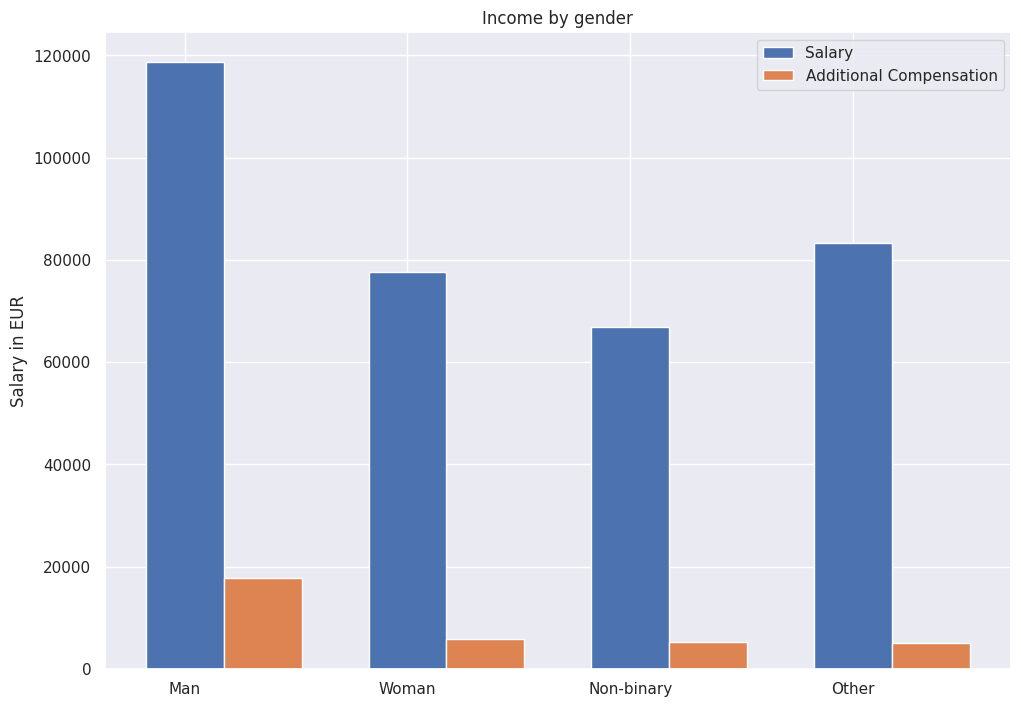

In [223]:
gender_income = df.groupby('gender')[['salary', 'add_comp']].mean()
other = gender_income.iloc[2:4, :].mean()

gender_income.loc['Other'] = other
gender_income = gender_income.drop(gender_income.iloc[2:4, :].index)

new_indices = [0, 2, 1, 3]
gender_income = gender_income.iloc[new_indices]
labels = ["Man", "Woman", "Non-binary", "Other"]

barplots(averages=gender_income, width=0.35, labels=labels, title="Income by gender")

Despite the poor dataset, pretty nice graph huh? Let's do the same for the other categories

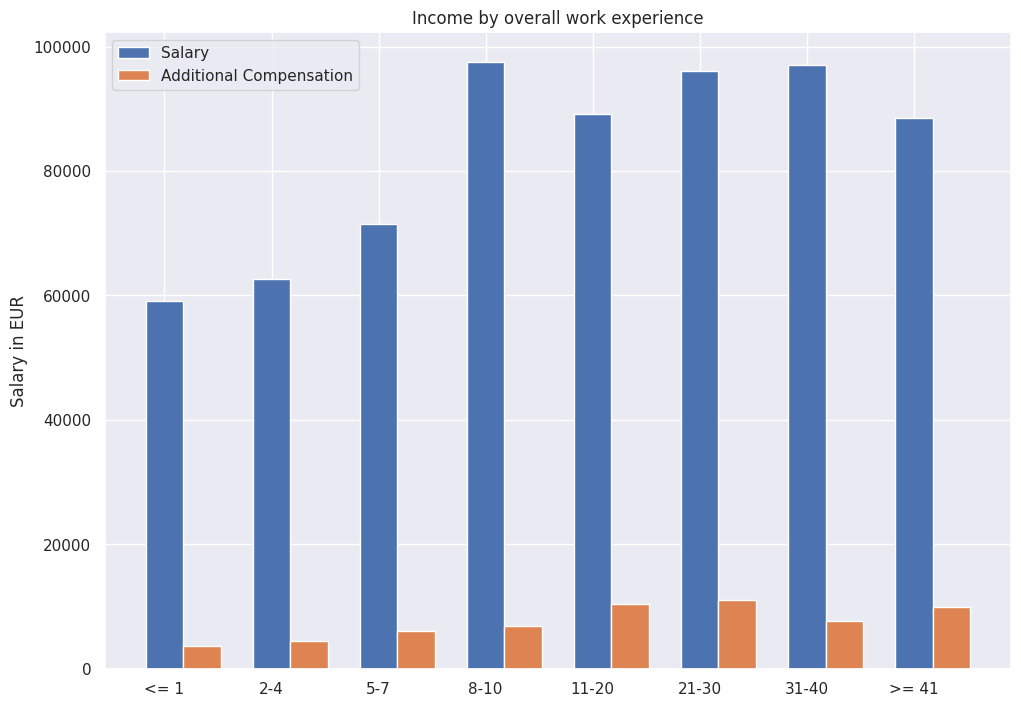

In [224]:
overall_exp_mean = df.groupby('overall_exp')[['salary', 'add_comp']].mean()

new_indices = [0, 2, 6, 7, 1, 3, 4, 5]
overall_exp_mean = overall_exp_mean.iloc[new_indices]
labels = ["<= 1", "2-4", "5-7", "8-10", "11-20", "21-30", "31-40", ">= 41"]

barplots(averages=overall_exp_mean, width=0.35, labels=labels, title="Income by overall work experience")

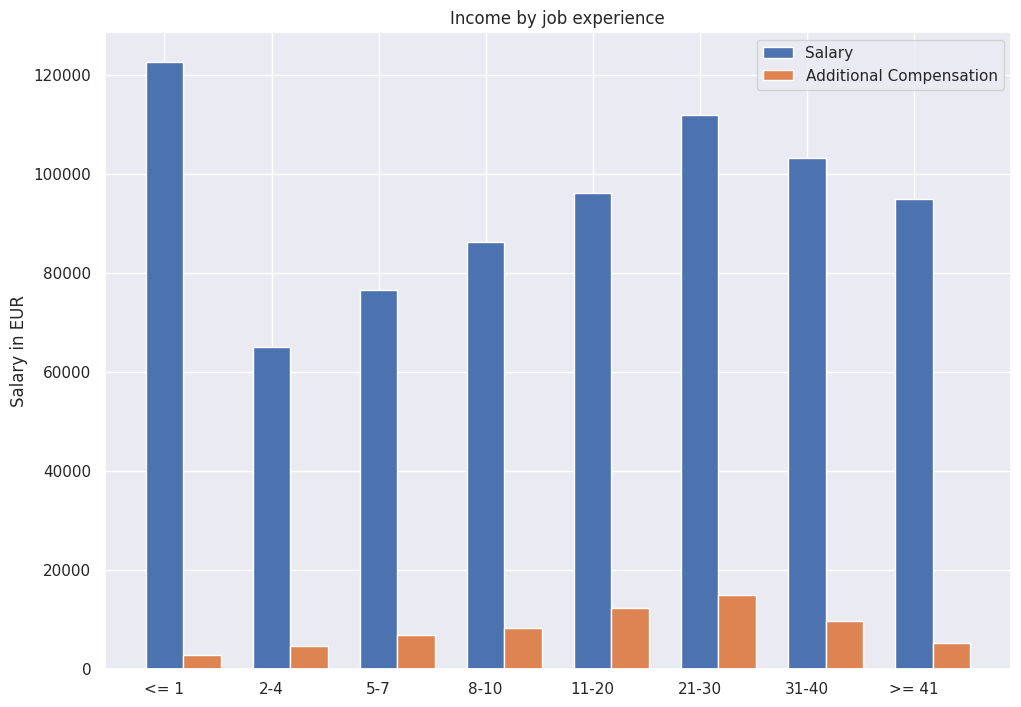

In [225]:
job_exp_mean = df.groupby('job_exp')[['salary', 'add_comp']].mean()

new_indices = [0, 2, 6, 7, 1, 3, 4, 5]
job_exp_mean = job_exp_mean.iloc[new_indices]
labels = ["<= 1", "2-4", "5-7", "8-10", "11-20", "21-30", "31-40", ">= 41"]

barplots(averages=job_exp_mean, width=0.35, labels=labels, title="Income by job experience")

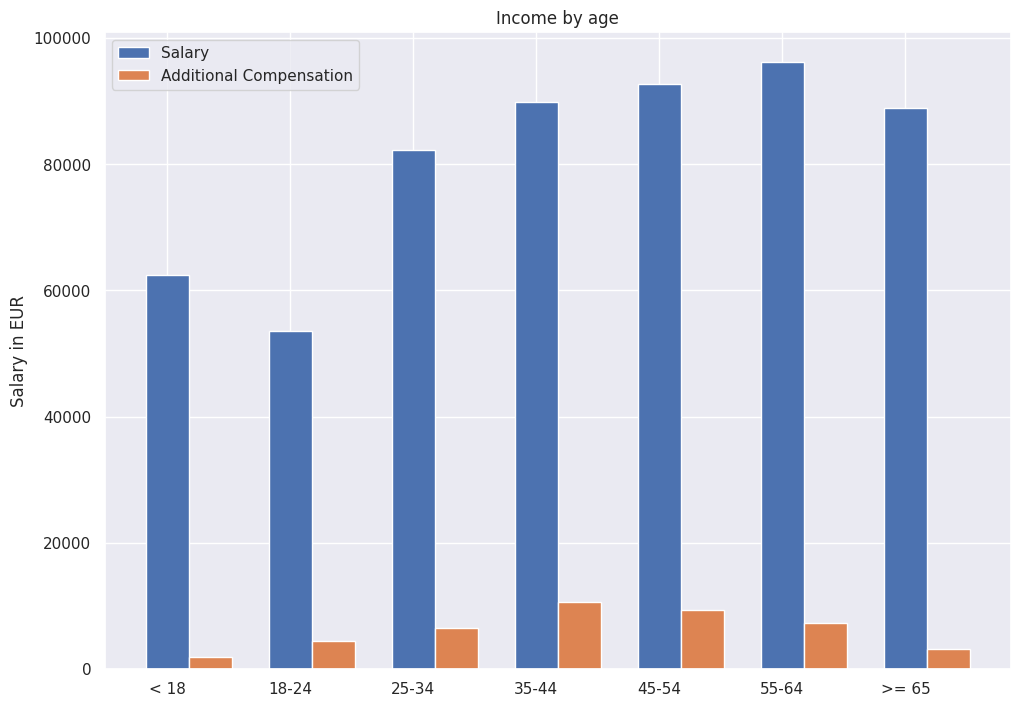

In [226]:
age_mean = df.groupby('age')[['salary', 'add_comp']].mean()

new_indices = [6, 0, 1, 2, 3, 4, 5]
age_mean = age_mean.iloc[new_indices]
labels = ["< 18", "18-24", "25-34", "35-44", "45-54", "55-64", ">= 65"]

barplots(averages=age_mean, width=0.35, labels=labels, title="Income by age")

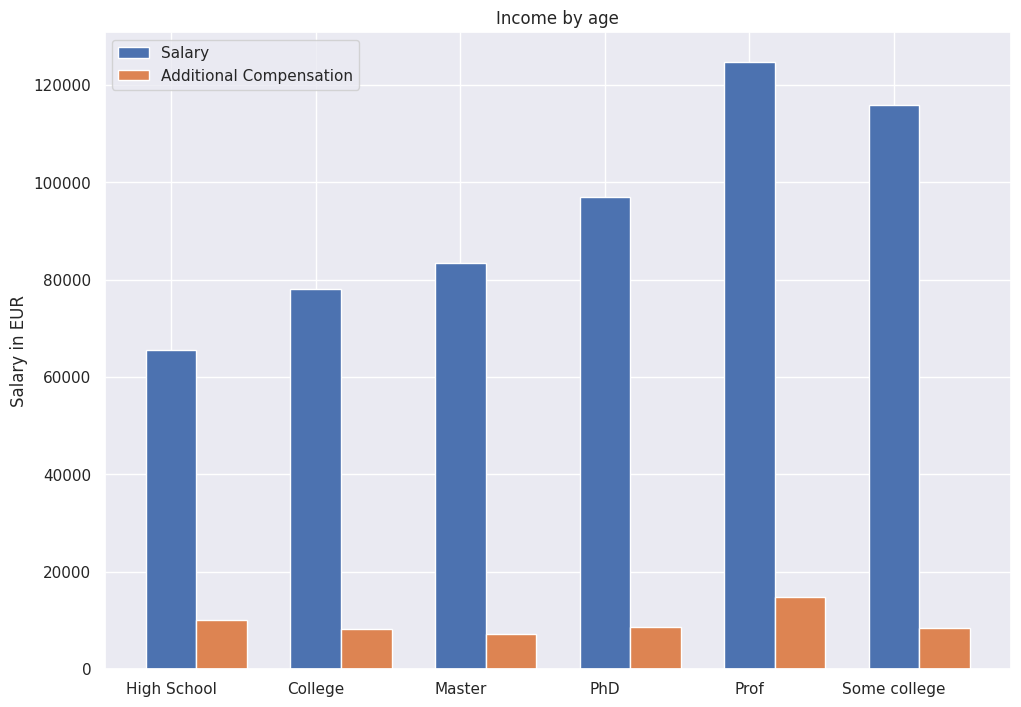

In [227]:
education_mean = df.groupby('education')[['salary', 'add_comp']].mean()

new_indices = [1, 0, 2, 3, 4, 5]
education_mean = education_mean.iloc[new_indices]
labels = ["High School", "College", "Master", "PhD", "Prof", "Some college"]

barplots(averages=education_mean, width=0.35, labels=labels, title="Income by age")

Remove the upper outliers for boxplots

In [228]:
df_small = df.drop(df[df['salary'] > 500000].index)

<Axes: xlabel='education', ylabel='salary'>

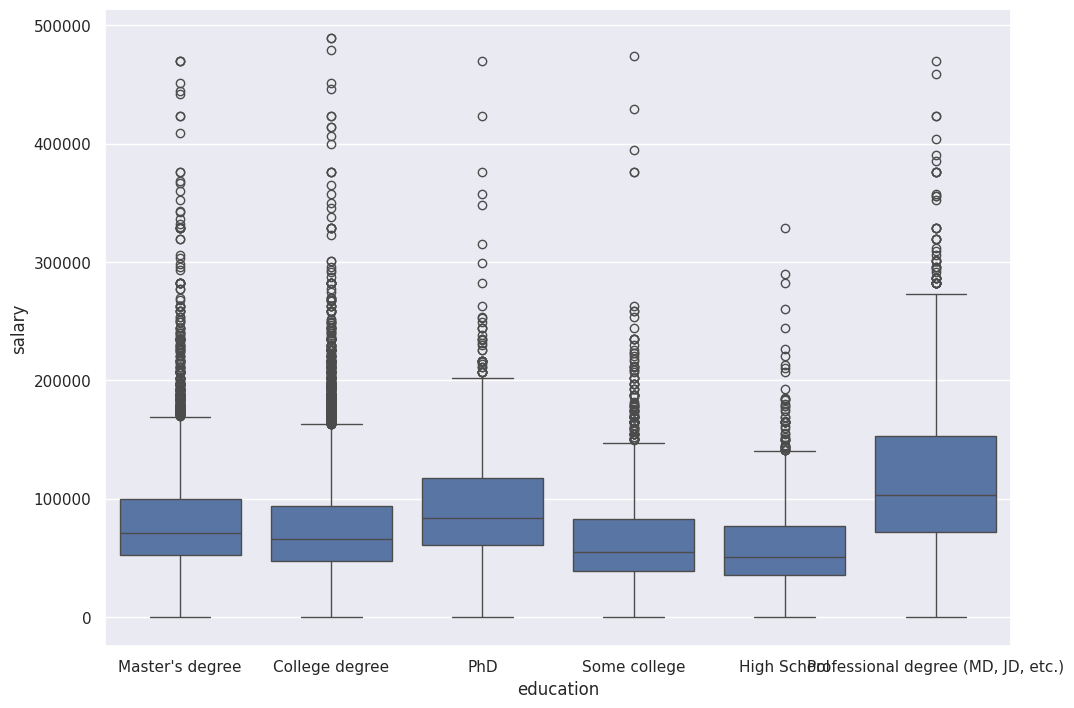

In [233]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(x=df_small['education'], y=df_small['salary'])

<Axes: xlabel='age', ylabel='salary'>

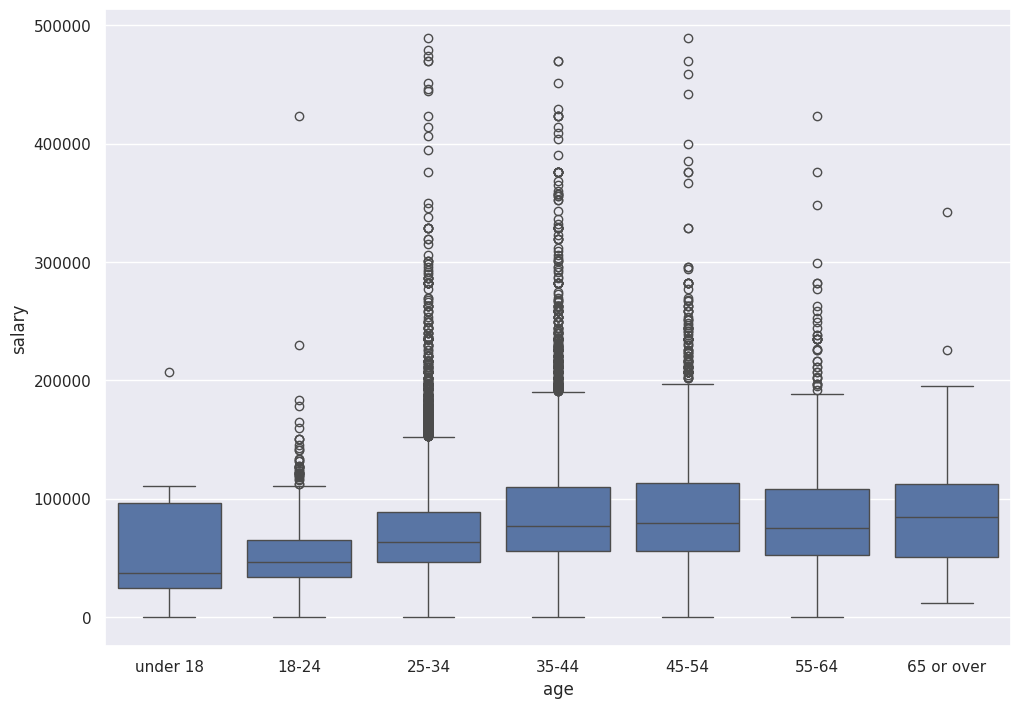

In [230]:
sns.boxplot(x=df_small['age'], y=df_small['salary'], order=["under 18", "18-24", "25-34", "35-44", "45-54", "55-64", "65 or over"])

<Axes: xlabel='gender', ylabel='salary'>

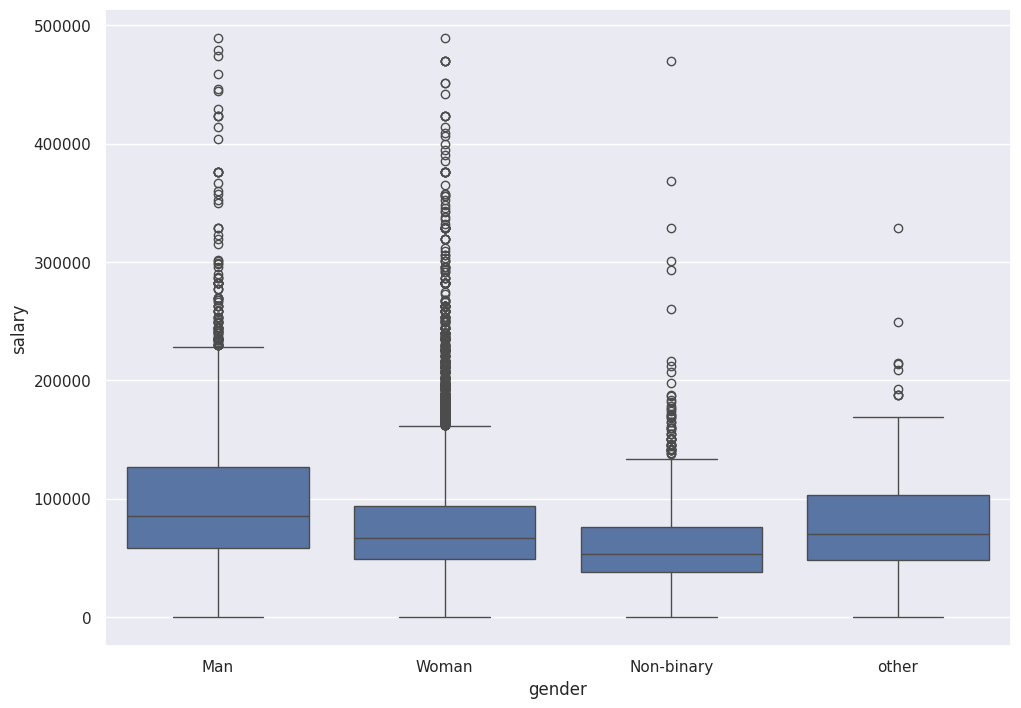

In [231]:
df_small['gender'] = df_small['gender'].apply(lambda x: 'other' if x in ["Other or prefer not to answer", "Prefer not to answer"] else x)
df_small['gender'].value_counts()

sns.boxplot(x=df_small['gender'], y=df_small['salary'], order=["Man", "Woman", "Non-binary", "other"])

/tmp/ipykernel_267212/677068517.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = plot.set_xticklabels(["<= 1", "2-4", "5-7", "8-10", "11-20", "21-30", "31-40", ">= 41"])


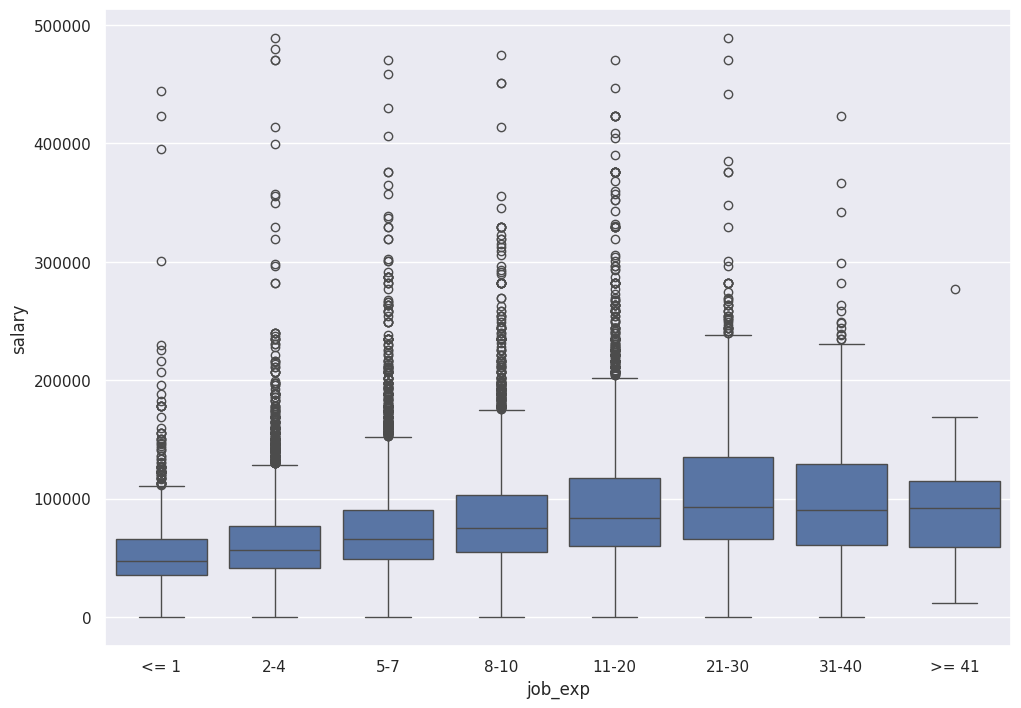

In [246]:
order=["1 year or less", "2 - 4 years", "5-7 years", "8 - 10 years", "11 - 20 years", "21 - 30 years", "31 - 40 years", "41 years or more"]
plot = sns.boxplot(x=df_small['job_exp'], y=df_small['salary'], order=order)
plot = plot.set_xticklabels(["<= 1", "2-4", "5-7", "8-10", "11-20", "21-30", "31-40", ">= 41"])

/tmp/ipykernel_267212/2718849123.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = plot.set_xticklabels(["<= 1", "2-4", "5-7", "8-10", "11-20", "21-30", "31-40", ">= 41"])


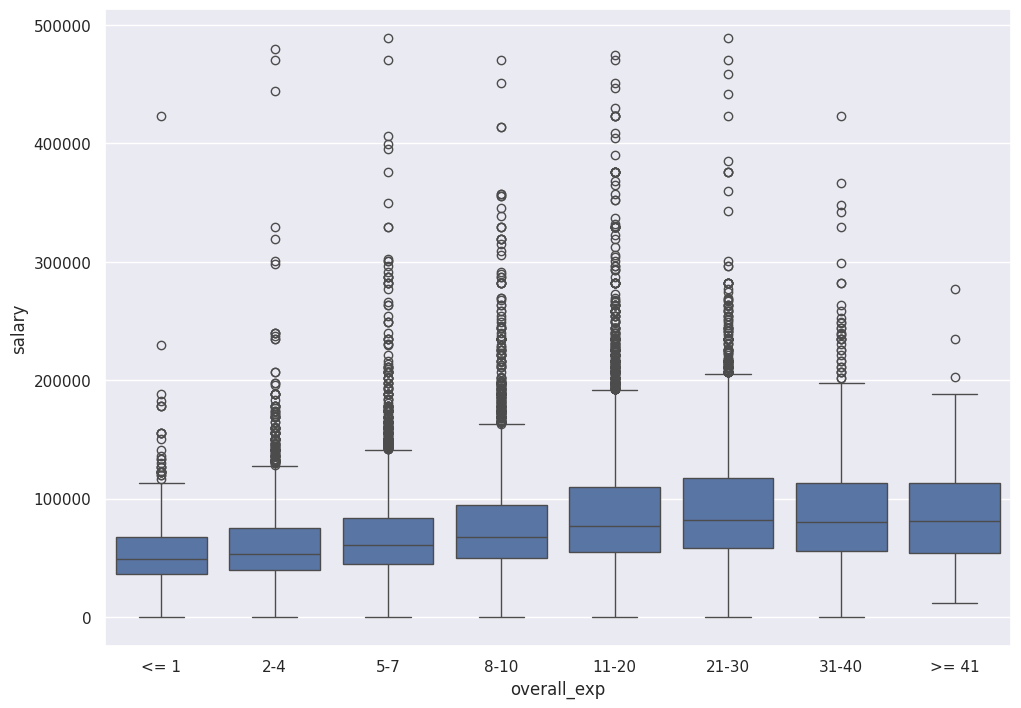

In [252]:
order=["1 year or less", "2 - 4 years", "5-7 years", "8 - 10 years", "11 - 20 years", "21 - 30 years", "31 - 40 years", "41 years or more"]
plot = sns.boxplot(x=df_small['overall_exp'], y=df_small['salary'], order=order)
plot = plot.set_xticklabels(["<= 1", "2-4", "5-7", "8-10", "11-20", "21-30", "31-40", ">= 41"])